In [1]:
import numpy as np
from scipy import interpolate

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,8)
x=np.linspace(5.0,150.0,300)

In [3]:
#from confidence_ellipse import confidence_ellipse
from quadrature_error import quadrature_error_relative

# Calibration

## Setup for atmosphere Argon and Stainless Steel ball

https://www.mathesongas.com/pdfs/flowchart/602%20(E300)/ARGON%20602(E300)%20SS%200%20PSIG.pdf

$\phi_{\text{Ar}}(z)$

In [4]:
ro,cal=np.loadtxt('ARGON_602(E300)_SS_0_PSIG.dat',unpack=True) # sccm
arflowSS=interpolate.interp1d(ro, cal)

## Setup for atmosphere Carbon Dioxide and Glass ball
https://www.mathesongas.com/pdfs/flowchart/602%20(E300)/CARBON%20DIOXIDE%20602(E300)%20GLASS%200%20PSIG.pdf

$\phi_{\text{CO}_2}(z)$

In [5]:
ro,cal=np.loadtxt('CARBON_DIOXIDE_602(E300)_GLASS_0_PSIG.dat',unpack=True) # sccm
co2flowPY=interpolate.interp1d(ro, cal)

## Setup for atmosphere Carbon Dioxide and Stainless Steel ball

https://www.mathesongas.com/pdfs/flowchart/602%20(E300)/CARBON%20DIOXIDE%20602(E300)%20SS%200%20PSIG.pdf


In [6]:
ro,cal=np.loadtxt('CARBON_DIOXIDE_602(E300)_SS_0_PSIG.dat',unpack=True) # sccm
co2flowSS=interpolate.interp1d(ro, cal)

## Plots

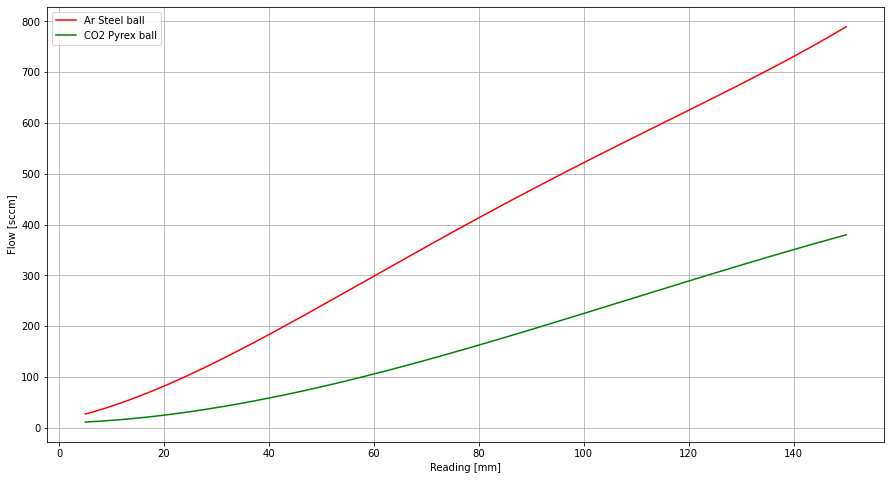

In [7]:
plt.plot(x, arflowSS(x), 'r', label='Ar Steel ball')
plt.plot(x, co2flowPY(x),'g', label='CO2 Pyrex ball')
plt.xlabel('Reading [mm]')
plt.ylabel('Flow [sccm]')
plt.grid()
plt.legend(loc='upper left')
plt.show()

# Determination of the flow prior to mixing

Carbon Dioxide flow $\phi_{\text{CO}_2}(z_1)$ for reading $z_1$

*pic goes here*

In [8]:
z1=85 # reading of glass ball
inCO2Flow=co2flowPY(z1)
print(f'CO2 inflow {inCO2Flow:.0f} sccm')

CO2 inflow 178 sccm


Argon flow $\phi_{\text{Ar}}(z_2)$ for reading $z_2$

*pic goes here*

In [9]:
z2=90 # reading of stainless stell ball
inArFlow=arflowSS(z2)
print(f'Ar inflow {inArFlow:.0f} sccm')

Ar inflow 469 sccm


Total flow prior to mixing $\phi_{\text{sum}}=\phi_{\text{CO}_2}(z_1)+\phi_{\text{Ar}}(z_2)$

In [10]:
totFlow=inCO2Flow+inArFlow
print(f'Total input Flow {totFlow:.0f} sccm')

Total input Flow 647 sccm


Calculate CO$_2$ fraction $\eta_{\text{CO}_2}=\tfrac{\phi_{\text{CO}_2}(z_1)}{\phi_{\text{sum}}}$

In [11]:
co2frac=inCO2Flow/totFlow
print(f'CO2 fraction {co2frac*100:.0f}%')

CO2 fraction 28%


## Error Estimation

This document

https://www.mathesongas.com/sites/default/files/inline-files/Model-FM-1050-High-Accuracy-Flowmeters.pdf

reports that the accuracy of the tube is $\pm5\%$ of full scale flow rate.

The full scale rate for Argon using the calibration above is 790 sccm

In [12]:
Arerr=790.*0.05
print(f'Argon flow rate measurement accuracy: {Arerr:.1f}sccm')

Argon flow rate measurement accuracy: 39.5sccm


The full scale rate for Argon using the calibration above is 380 sccm

In [13]:
CO2err=380.*0.05
print(f'Carbon Dioxide flow rate measurement accuracy: {CO2err:.1f}sccm')

Carbon Dioxide flow rate measurement accuracy: 19.0sccm


Therefore the total flow rate is 

In [14]:
totErr=Arerr+CO2err
print(f'({totFlow:.0f} +/- {totErr:.0f}) sccm')

(647 +/- 58) sccm


The error for the Carbon Dioxide fraction is calcualted in quadrature

In [15]:
co2fracErr=co2frac*quadrature_error_relative(np.array([inCO2Flow,totFlow]),np.array([CO2err,totErr]))
print(f'CO2 fraction ({co2frac*100:.0f} +/- {co2fracErr*100:.0f})%')

CO2 fraction (28 +/- 4)%


# Determination of the flow of a gas mixture

## Calculate correction for different gas mixture - Version 1

According to 
https://www.mathesongas.com/pdfs/flowchart/RotameterGasFactorChart.pdf
the recipe to determine the flow rate of a gas mixture $\phi_{\text{mix}}$ is to calculate the weighted average of the gas factors $f_i$ 
$$ F = \sum_i{ f_i \frac{v_i}{V_{\text{tot}}}} $$
and to multiply the calibration for air $\phi_{\text{air}}(z)$ by it
$$ \phi_{\text{mix}}(z) = F \phi_{\text{air}}(z) $$. 

The weights are assumed to be the fractional volume of the mixture $\eta=\tfrac{v_i}{V_{\text{tot}}}$.

In [16]:
Ar_factor=0.851
CO2_factor=0.808

Mixture fraction $\eta_{\text{Ar}}=1-\eta_{\text{CO}_2}$

In [17]:
mix_factor=((1.0-co2frac)*Ar_factor)+(co2frac*CO2_factor)
print(f'The mix factor is {mix_factor:.5f}')

The mix factor is 0.83916


## Setup for atmosphere Air and Stainless Steel ball

https://www.mathesongas.com/pdfs/flowchart/602%20(E300)/AIR%20602(E300)%20SS%200%20PSIG.pdf


In [18]:
ro,cal=np.loadtxt('AIR_602(E300)_SS_0_PSIG.dat',unpack=True) # sccm
airflow=interpolate.interp1d(ro, cal)

## Calculate correction for different gas mixture - Version 2

There is another way to calcualte the flow rate of a gas mixture and is as follows
$$ \phi_{\text{mix}}(z) = \eta_{\text{Ar}} \phi_{\text{Ar}}(z) +  \eta_{\text{CO}_2} \phi_{\text{CO}_2}(z) $$

In [19]:
mixflow=interpolate.interp1d(x,(1.0-co2frac)*arflowSS(x)+co2frac*co2flowSS(x))

## Plots

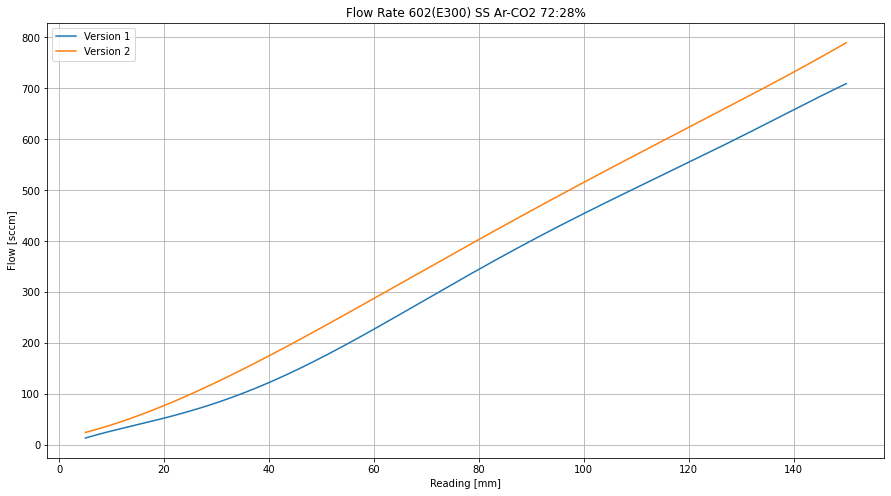

In [20]:
plt.plot(x, airflow(x)*mix_factor, label='Version 1')
plt.plot(x, mixflow(x), label='Version 2')
plt.xlabel('Reading [mm]')
plt.ylabel('Flow [sccm]')
plt.grid()
plt.title(f'Flow Rate 602(E300) SS Ar-CO2 {(1.-co2frac)*100:1.0f}:{co2frac*100:1.0f}%')
plt.legend(loc='upper left')
plt.show()

## Readout of the SS ball

In [21]:
inSS=105
outSS=55

Determine input flow post mixing with calculation "version 1"

In [22]:
inFlowV1=airflow(inSS)*mix_factor
print(f'Gas Mixture inflow {inFlowV1:.0f} sccm')

Gas Mixture inflow 480 sccm


Determine input flow post mixing with calculation "version 2"

In [23]:
inFlowV2=mixflow(inSS)
print(f'Gas Mixture inflow {inFlowV2:.0f} sccm')

Gas Mixture inflow 543 sccm


Determine output flow

In [24]:
outFlow=airflow(outSS)*mix_factor
print(f'Gas Mixture outflow {outFlow:.0f} sccm')

Gas Mixture outflow 199 sccm


Determine return fraction

In [25]:
print(f'Return fraction {outFlow/inFlowV1*100.0:.0f}%')

Return fraction 41%


## Error Estimation

The error on the "version 1" calcuation is obtained from the full scale rate for the gas mixture using the calibration above and is as follows:

In [26]:
mix_maxrate=airflow(150.)*mix_factor
print(f'Max flow rate for mixture {mix_maxrate:.0f} sccm')
mixerrV1=mix_maxrate*0.05

Max flow rate for mixture 709 sccm


The error on the "version 2" is determined in quadrature

In [27]:
CO2err=790.*0.05
temp1=(1.-co2frac)*arflowSS(inSS)*quadrature_error_relative(np.array([(1.-co2frac),arflowSS(inSS)]),
                                                            np.array([co2fracErr,Arerr]))
temp2=co2frac*co2flowSS(inSS)*quadrature_error_relative(np.array([co2frac,co2flowSS(inSS)]),
                                                        np.array([co2fracErr,CO2err]))
mixerrV2=temp1+temp2

Therefore the input and output flow rate of the mixture are

In [28]:
print(f'Input ver.1: ({inFlowV1:.0f} +/- {mixerrV1:.0f}) sccm')
print(f'Input ver.2: ({inFlowV2:.0f} +/- {mixerrV2:.0f}) sccm')
print(f'Output: ({outFlow:.0f} +/- {mixerrV1:.0f}) sccm')

Input ver.1: (480 +/- 35) sccm
Input ver.2: (543 +/- 59) sccm
Output: (199 +/- 35) sccm


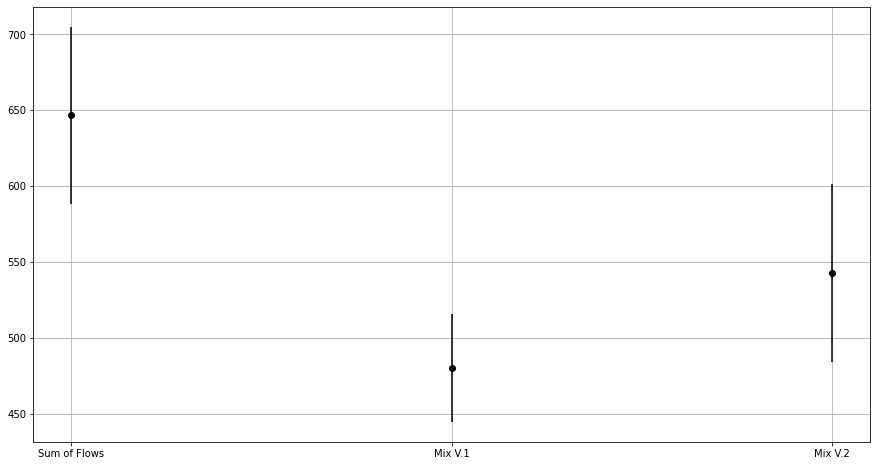

In [29]:
n=range(3)
plt.errorbar(n, [totFlow,inFlowV1,inFlowV2], yerr=[totErr,mixerrV1,mixerrV2], label='', fmt='ok')
plt.xticks(n, ('Sum of Flows','Mix V.1','Mix V.2'))
_,ymax=plt.ylim()
#plt.ylim(0.,ymax)
plt.grid()
plt.show()